# Getting starting with the GRIDmeter™ library

This jupyter notebook is an interactive tutorial. It walks through loading data, running the stratified sampling model, and plotting results. You'll run all the code yourself. Cells can be executed with `<shift><enter>`. If you feel so inspired, make edits to the code in these cells and dig deeper.


    

# Background -- why this library

The `gridmeter` library originated from a project lead by Recurve Analytics, Inc. and funded by the US Dept. of Energy designed to identify practical methods for analyzing energy efficiency which are robust to external shocks (e.g. COVID-19).  From June through September 2020, Recurve hosted a series of meetings with industry stakeholders to discuss methods for constructing comparison groups, with the goal of presenting a recommended standard method to the GRID working group, a subsidiary of the Linux Foundation for Energy.  During this time, Recurve developed Python software to implement stratified sampling and demonstrate its effectiveness in practice.  The `gridmeter` library is the open-source Apache-licensed output of this process and is available to be used by anyone. 

This notebook will take you through several things that this library can do.


## Note on tutorial scope and related libraries

This tutorial assumes the reader has properly installed python and has a basic working knowledge of python syntax and usage. 

The `gridmeter` library uses `pandas` data frames as its principle way of representing data, therefore all inputs and outputs are data frames; see [this tutorial](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html) for information on how to use `pandas`.  The `plotnine` library is used to make visualizations which can be embedded in a Jupyter notebook or saved as .pngs; see [this website](https://plotnine.readthedocs.io/en/stable/) for information on `plotnine`.

In [1]:
import subprocess
import sys

for package in ['gridmeter', 'pandas', 'plotnine']:
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as pn
import gridmeter as gm

## Viewing documentation

You can view code documentation by appending a question mark to a function and then executing that code, as in the following example:

In [2]:
gm.Stratified_Sampling?

Init signature: gm.Stratified_Sampling(settings: 'Settings | None' = None)
Docstring:      <no docstring>
File:           /app/applied_data_science/gridmeter/gridmeter/gridmeter/_stratified_sampling/create_comparison_groups.py
Type:           type
Subclasses:     

# Problem definition

Typically one begins with two populations of meters: a **treatment group**, and a **comparison pool**.  The treatment group consists of those meters for which savings needs to be tracked, e.g. if they represent customers participating in an energy efficiency program.  The comparison pool consists of all of the available meters that are not part of the treatment group.  The goal is to select a **comparison group** which is a subset of the comparison pool, such that the control group is **similar** to the treatment group.  The comparison group will then provide a realistic counterfactual compared to the treatment group and can be used to accurately estimate the impact of a program.

# Setting up tutorial data

Ordinarily you would start with your own time-series meter data, but for our purposes we'll generate some very basic dummy data.  `gridmeter` provides some functions which generate populations of dummy meters with randomly varying base and peak usage levels.  We'll use the following code to generate a population of 1000 treatment meters and 10000 comparison pool meters, and specify some consumption values for the treatment group that differ from the default, so that the groups are differently distributed.  The treatment group is specified by filtering the comparison pool along one of the available features (currently `winter_usage`, `summer_uage`, and `annual_usage`).  For this example, we'll assume our treatment group targets customers with usage above the 50th percentile in both summer and winter.

Once the population has been generated, we can create feature data and longitudinal data.  These functions take a few minutes to run upon first execution, but the results are cached to disk so subsequent runs will be fast.

Note: the structure of the dataframes is extremely important going forward.

In [3]:
# Loadshape and feature data

n_treatment = 100
n_pool = 1000

filter = lambda df: df[(df.summer_usage > df.summer_usage.quantile(0.5)) & (df.winter_usage > df.winter_usage.quantile(0.5))]
population = gm.DummyTreatmentPoolPopulation(n_treatment=n_treatment, n_pool=n_pool, 
                                              treatment_filter_function=filter)

df_features= population.features()
df_features_pool = df_features[df_features['set']=='pool']
df_features_treatment = df_features[df_features['set']=='treatment']
df_loadshape = population.features_monthly()

df_features_pool = df_features_pool.rename(columns={'meter_id':'id'}).drop(columns=['set'])
df_ls_pool = df_loadshape.loc[df_features_pool["id"]]
df_ls_pool = df_ls_pool.stack().reset_index().rename(columns={'meter_id':'id', 'month':'time', 0:'loadshape'})

df_features_treatment = df_features_treatment.rename(columns={'meter_id':'id'}).drop(columns=['set'])
df_ls_treatment = df_loadshape.loc[df_features_treatment["id"]]
df_ls_treatment = df_ls_treatment.stack().reset_index().rename(columns={'meter_id':'id', 'month':'time', 0:'loadshape'})

# Fake time series data
# Create a testing dataframe having an id, datetime of 1 month intervals, observed and modeled values 
num_intervals = 12  # 1 per month

# Create a DataFrame with 'id', 'datetime', 'observed', and 'modeled' columns
df_ts_treatment = pd.DataFrame({
    'id': np.repeat(df_features_treatment["id"].values, num_intervals),  # only 3 ids for easier comparison
    'datetime': pd.date_range(start='2023-01-01', periods=num_intervals, freq='M').tolist() * n_treatment, 
    'observed': np.random.rand(num_intervals * n_treatment),  # randomized
    'modeled': np.random.rand(num_intervals * n_treatment)  # randomized
})

INFO:root:Caching objects to .cache


In [4]:
# Loadshape dataframe format, columns: [id, time, loadshape]
# time depends on whatever you have aggregated to

print("Loadshape dataframe format:")
df_ls_treatment.head()

Loadshape dataframe format:


,id,time,loadshape
0,meter_8,1,1715.839526
1,meter_8,2,1526.409037
2,meter_8,3,1693.203681
3,meter_8,4,1356.354862
4,meter_8,5,1369.432251


In [5]:
# Time Series dataframe format, columns: [id, datetime, Optional[observed], Optional[modeled], Optional[error]]
# observed, modeled, and error are optional, but at least one must be present
# if you are using observed and modeled to calculate error, then you must have both observed and modeled

print("Time series dataframe format:")
df_ts_treatment.head()

Time series dataframe format:


,id,datetime,observed,modeled
0,meter_8,2023-01-31,0.234517,0.431976
1,meter_8,2023-02-28,0.455931,0.998989
2,meter_8,2023-03-31,0.841495,0.351410
3,meter_8,2023-04-30,0.654993,0.679868
4,meter_8,2023-05-31,0.729565,0.870597


In [6]:
# Features dataframe format, columns: [id, feature1, feature2, ...]
# features can be named whatever you like and you may include as many as you like

print("Features dataframe format:")
df_features_treatment.head()

Features dataframe format:


,id,winter_usage,summer_usage,annual_usage
8,meter_8,4471.119636,4178.528812,16789.467345
31,meter_31,4758.167137,4224.936325,18369.772968
37,meter_37,4655.875657,4081.356379,18643.625942
43,meter_43,4508.469874,4146.107295,16636.552913
47,meter_47,4536.487872,4143.014120,16913.873090


# Setting up data

Gridmeter uses the `Data` class as the inputs to all of the comparison group methods. Its purpose is to validate your data and to perform the necessary transformations to go into the comparison group methods. `Data` is instantiated with `Data_Settings`. Once instantiated the method `.set_data` can be called using one of `loadshape_df` and `time_series_df` as well as `features_df` depending upon your needs. If you input `time_series_df` it will compute the loadshape.

Method requirements:
- Clustering: Loadshape
- Individual Meter Matching: Loadshape
- Stratified Sampling: Loadshape/Features (depends upon settings)

In [7]:
data_settings = gm.Data_Settings(time_period='month')

In [8]:
# Let's make an invalid entry to see what happens
df_ts_treatment.loc[0, 'observed'] = np.nan

ts_data = gm.Data().set_data(time_series_df=df_ts_treatment)

ts_data.get_excluded_ids()

,id,reason
0,meter_100,missing minimum number of values in loadshape_df
1,meter_1010,missing minimum number of values in loadshape_df
2,meter_1012,missing minimum number of values in loadshape_df
3,meter_1016,missing minimum number of values in loadshape_df
4,meter_102,missing minimum number of values in loadshape_df
...,...,...
95,meter_961,missing minimum number of values in loadshape_df
96,meter_970,missing minimum number of values in loadshape_df
97,meter_98,missing minimum number of values in loadshape_df
98,meter_987,missing minimum number of values in loadshape_df


In [9]:
# Set data classes
# for the purposes of this tutorial, we'll set both loadshapes and features

data_settings = gm.Data_Settings(AGG_TYPE=None, LOADSHAPE_TYPE=None, TIME_PERIOD=None)

pool_data = gm.Data(data_settings)
pool_data.set_data(loadshape_df=df_ls_pool, features_df=df_features_pool)

treatment_data = gm.Data(data_settings)
treatment_data.set_data(loadshape_df=df_ls_treatment, features_df=df_features_treatment)

In [10]:
treatment_data.get_loadshape()

,1,2,3,4,5,6,7,8,9,10,11,12
id,,,,,,,,,,,,
meter_100,1524.333493,1592.385533,1440.361155,1354.306709,1435.969797,1311.420694,1133.036542,1363.312919,1328.796127,1681.705116,1463.240453,1706.510352
meter_1010,1644.459826,1813.744645,1552.891154,1011.469422,1175.392677,1204.147979,1498.161604,1174.978344,1382.427064,1368.590562,1604.078031,1595.159738
meter_1012,1495.105851,1854.691275,1227.499495,1298.745046,1017.665449,1721.068561,1168.031159,1462.209605,1205.661471,1299.302650,1285.040508,1679.761536
meter_1016,1129.317873,1539.238443,1350.541279,1474.277355,1353.241178,1724.918736,1255.436914,1505.634618,1340.939863,1540.918175,1404.087898,1390.733445
meter_102,1521.060375,1582.060123,1629.971156,1512.226675,1645.186457,1972.403721,1571.723923,1766.072487,1451.001625,1934.242219,1610.656971,1463.226732
...,...,...,...,...,...,...,...,...,...,...,...,...
meter_961,1520.540264,1545.530996,1555.578629,1438.105346,1295.064110,1429.870443,1401.996696,1404.824555,1810.986263,1496.181209,1467.778336,1699.544657
meter_970,1730.752978,1480.467858,1402.143396,1261.578337,1352.699013,1488.524208,1628.009749,1329.827559,1394.186935,1316.222676,1350.297676,1530.490122
meter_98,1525.499380,1511.468138,1213.226594,1351.193119,1290.032238,1531.290280,1509.677542,1284.087392,1493.607567,1245.568381,1285.123062,1488.805435


In [11]:
treatment_data.get_features()

,winter_usage,summer_usage,annual_usage
id,,,
meter_8,4471.119636,4178.528812,16789.467345
meter_31,4758.167137,4224.936325,18369.772968
meter_37,4655.875657,4081.356379,18643.625942
meter_43,4508.469874,4146.107295,16636.552913
meter_47,4536.487872,4143.014120,16913.873090
...,...,...,...
meter_1045,4652.995496,4158.602723,17295.790873
meter_1053,4474.729151,4421.306270,17278.549835
meter_1066,4541.968424,4046.146944,17182.688477


In [12]:
data_settings

Data_Settings(AGG_TYPE=None, LOADSHAPE_TYPE=None, TIME_PERIOD=None, INTERPOLATE_MISSING=True, MIN_DATA_PCT_REQUIRED=0.8, SEASON=Season_Definition(JANUARY='winter', FEBRUARY='winter', MARCH='shoulder', APRIL='shoulder', MAY='shoulder', JUNE='summer', JULY='summer', AUGUST='summer', SEPTEMBER='summer', OCTOBER='shoulder', NOVEMBER='winter', DECEMBER='winter', OPTIONS=['summer', 'shoulder', 'winter']), WEEKDAY_WEEKEND=Weekday_Weekend_Definition(MONDAY='weekday', TUESDAY='weekday', WEDNESDAY='weekday', THURSDAY='weekday', FRIDAY='weekday', SATURDAY='weekend', SUNDAY='weekend', OPTIONS=['weekday', 'weekend']))

# Clustering

Is it fast? Not particularly, but it has advantages

In [ ]:
clustering_settings = gm.Clustering_Settings()
clustering = gm.Clustering(clustering_settings)
df_cg, df_t_coeffs = clustering.get_comparison_group(treatment_data, pool_data)
df_cg

In [ ]:
df_t_coeffs

In [ ]:
df_cg

# Individual Meter Matching
For Euclidean distance matching, the usage patterns of each treatment meter are compared to the usage patterns of each comparison pool meter in order to find the closest matches. The subsequent group of meters that have been "matched" become the resulting comparison group.

## Features For Matching

Any usage pattern can be used for euclidean distance matching. If an 8760 hourly trace is available, it is suggested to use a 'seasonal-hour-of-week' load-shape (3 168-point load shapes, one for summer, winter, and shoulder). If only monthly data is available, it is suggested to use the 12 months of usage as the usage pattern.


In [13]:
# Test IMM

imm_settings = gm.IMM_Settings()
imm = gm.IMM(imm_settings)
df_cg, df_t_coeffs = imm.get_comparison_group(treatment_data, pool_data)

/app/applied_data_science/gridmeter/gridmeter/gridmeter/_individual_meter_matching/distance_calc_selection.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


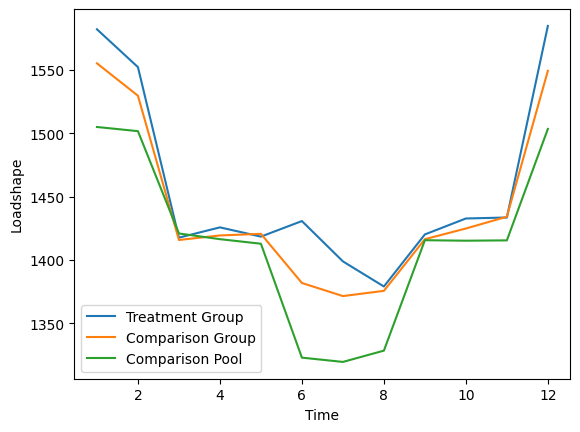

In [14]:
df = imm.plot_comparison_group_loadshape(id=None).T

# Stratified Sampling Matching

There are many ways to define similarity and many methods for constructing similar groups.  The stratified sampling approach was selected in particular because it offers a good balance in terms effectiveness, ease of implementation, and simplicity. We define stratified sampling as follows:

- Each meter is represented by a vector of numerical features, e.g. annual usage, summer peak usage, etc
- A small number of features, typically between 1 and 3 inclusive, are selected: this is the number of *dimensions*.
- The treatment group is divided up into a set of multidimensional bins according to a predefined binning configuration.
- The proportion of treatment meters present in each bin is computed.
- A set of meters is sampled from the comparison pool such that the sample is distributed amongst the bins in the same proportion as the treatment group.  The sample is called the comparison group.
- The treatment and comparison groups are compared using additional meter data, e.g. load shapes.
- (Optional) An optimal binning configuration is selected which minimizes error between treatment and control groups.


In order to use this library, it is therefore necessary to have the following data at hand:
- A data frame containing the treatment group, with one ID column, and a set of numerical feature columns, one row per meter;
- A data frame containing the comparison pool, in the same format;
- A data frame containing the treatment group data for equivalence, with one ID column, one feature name column, and one value column; e.g. for an annual monthly load shape, the feature name column might contain the month name, and there might be twelve rows per meter;
- A data frame containing the comparison pool data for equivalence, in the same format.

## Selecting features for stratification

Normally, you will compute a set of features from your time series meter traces, and then select a subset of those features to stratify on.  The feature computation step is up to you.  We recommend running the Caltrack model to derive heating and cooling coefficients and deriving features from these outputs.  Other techniques such as principle component analysis could be useful as well.  In general, aim for stratifying on between one and three features, and aim for orthogonal features if possible.  In the dummy data, there are three features available: `summer_usage`, `winter_usage`, and `annual_usage` which are shown in the scatter plots below.  `annual_usage` is correlated with the other two, as you would expect, so we will stratify based on `summer_usage` and `winter_usage`.



In [ ]:
pd.plotting.scatter_matrix(df_features_treatment);

By plotting the two features below we can see that the treatment group and comparison pool are differently distributed, such that a random sample from the pool would not be a good counterfactual for the treatment group -- this is why we need stratified sampling.

In [ ]:
pn.ggplot(df_features, pn.aes(x='summer_usage', y='winter_usage', color='set')) + pn.geom_point(alpha=0.5) + pn.facet_wrap("~set") + pn.theme_bw()

To use stratified sampling, you must supply input data, a list of input columns to stratify on, and some configuration, according to the example below.   Additionally, you have the option of using the library to select an optimal configuration for you.  We'll first demonstrate the basic usage of the model, in which you supply all of the configuration information.

### Number of outputs 

The size of the comparison group is constrained by the size of the pool and by the degree to which the treatment group overlaps the pool in terms of the stratification columns.  For example, if the treatment group and pool are disjoint, no comparison group can be constructed; if only 5% of the pool overlaps the treatment group, then the effective available pool is constructed from that 5% of overlapping meters.  Generally, if you do not specify the output size, `gridmeter` will construct the largest possible comparison group up to 5000 meters.   

In [ ]:
strat_col_settings = [
    {
        "column_name": "summer_usage", 
        "n_bins": 8, 
        "min_value_allowed": 3000, 
        "max_value_allowed": 6000, 
        "fixed_width": False
    },
    {
        "column_name": "winter_usage",
        "n_bins": 8, 
        "min_value_allowed": 3000, 
        "max_value_allowed": 6000, 
        "fixed_width": False
    },
]

ss_settings = gm.stratified_sampling_settings(stratification_column=strat_col_settings, random_seed=1)
ss = gm.Stratified_Sampling(ss_settings)

df_clusters, df_treatment_weights = ss.get_comparison_group(treatment_data, pool_data)

In [ ]:
# Original Stratified Sampling dataframe
ss.df_raw

In [ ]:
# bin count
ss.diagnostics().count_bins()

## Viewing diagnostic plots 

Once the model has been fit, you can view several plots which will show the treatment group, comparison pool, and the final sample (i.e. the comparison group).  If the model has worked correctly, then the sample should be distributed similarly to the treatment group.  There are three plots available:

1. Histograms, showing the distribution of each stratification parameter in one dimension;
2. Scatter plots, showing an XY-plot of data points for each pair of dimensions;
3. Quantile plots with equivalence, showing the quantile distribution of each dimension, along with t-test and ks-test p-values comparison the treatment and comparison groups.  

The t- and ks-tests can be used as a measure of equivalence, however we recommend using equivalence-based optimization discussed below for better results in practice.  

In [ ]:
d = ss.diagnostics()

In [ ]:
d.histogram()

In [ ]:
d.scatter()

In [ ]:
d.quantile_equivalence()

## Equivalence-based optimization

The above method of stratified sampling is designed to match the distributions of one or more stratification parameters.  However, often in practice the desired outcome is to have a comparison group with similar usage patterns to a treatment group as measured through a load shape or similar set of time-series features.  To ensure that the load shapes are equivalent, you can use the `StratifiedSamplingBinSelector` which selects an optimal binning arrangement which minimizes load shape error between the treatment and comparison groups. 

In the following example, a bin selector is used to match on monthly load shapes.  

In [ ]:
strat_col_settings = {
    "equivalence_method": "chisquare",
    "min_n_bins": 2,
    "max_n_bins": 8,
    "stratification_column": [{
            "column_name": "summer_usage", 
            "n_bins": None, 
            "min_value_allowed": 3000, 
            "max_value_allowed": 6000, 
            "fixed_width": False
        },
        {
            "column_name": "winter_usage",
            "n_bins": None, 
            "min_value_allowed": 3000, 
            "max_value_allowed": 6000, 
            "fixed_width": False
    }],
    "random_seed": 1,
}

dss_settings = gm.distance_stratified_sampling_settings(**strat_col_settings)
dss = gm.Stratified_Sampling(dss_settings)

df_clusters2, df_treatment_weights2 = dss.get_comparison_group(treatment_data, pool_data)

In [ ]:
dss.model_bin_selector.plot_records_based_equiv_average()

The graph above shows the monthly load shape of the treatment group (red), the selected comparison group (black), other candidate comparison groups (blue), and the comparison pool (dots).  In this case, all of the candidates were a good match, so the selection process was probably unnecessary, however in more complex cases this method can be useful.  The final binning arrangement is available in the model object as follows:

In [ ]:
dss.diagnostics().scatter()

In [ ]:
dss.df_raw

This concludes the tutorial.  For questions, comments, or issues, please raise a Github issue here:  
https://github.com/recurve-methods/comparison_groups/issues

We thank you for your interest and participation in this project and look forward to your feedback.